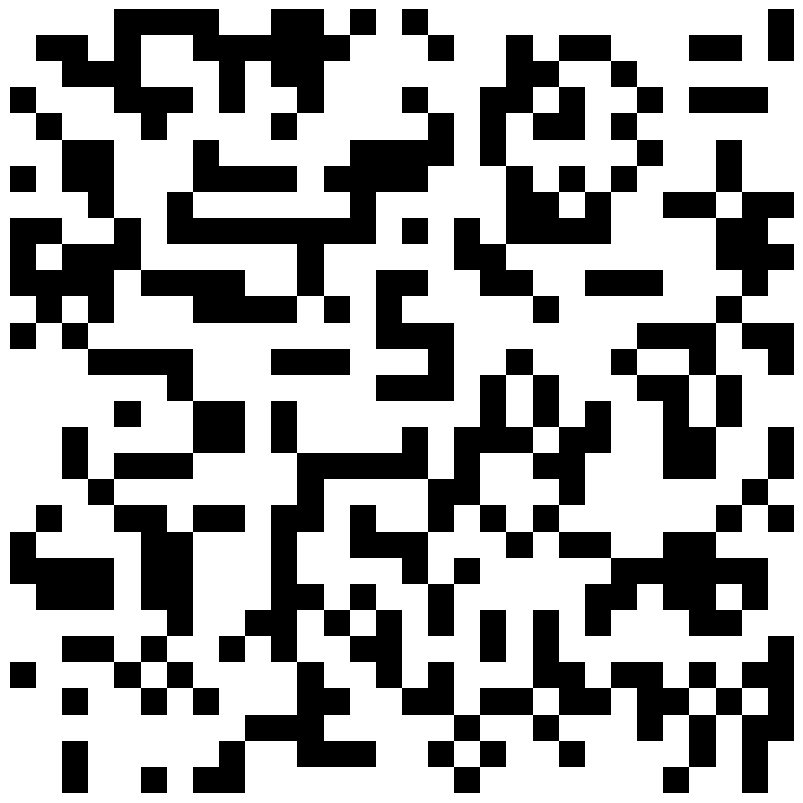

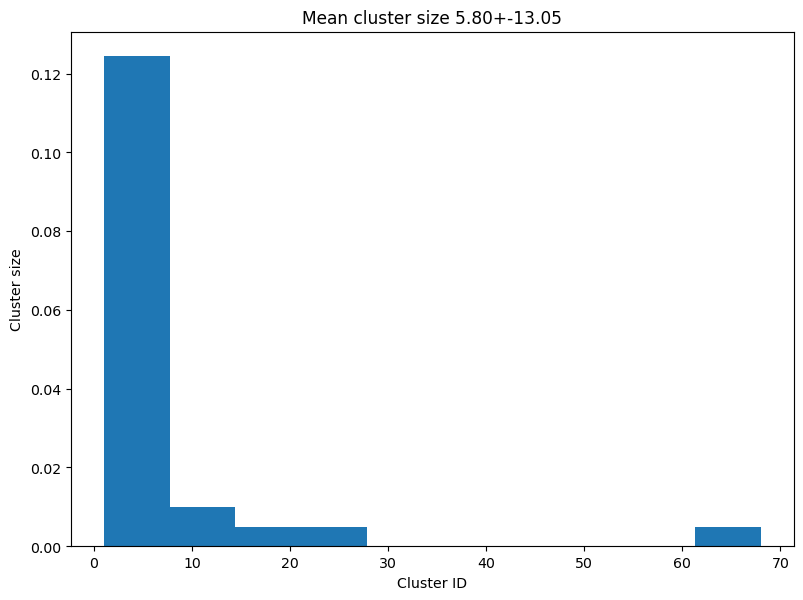

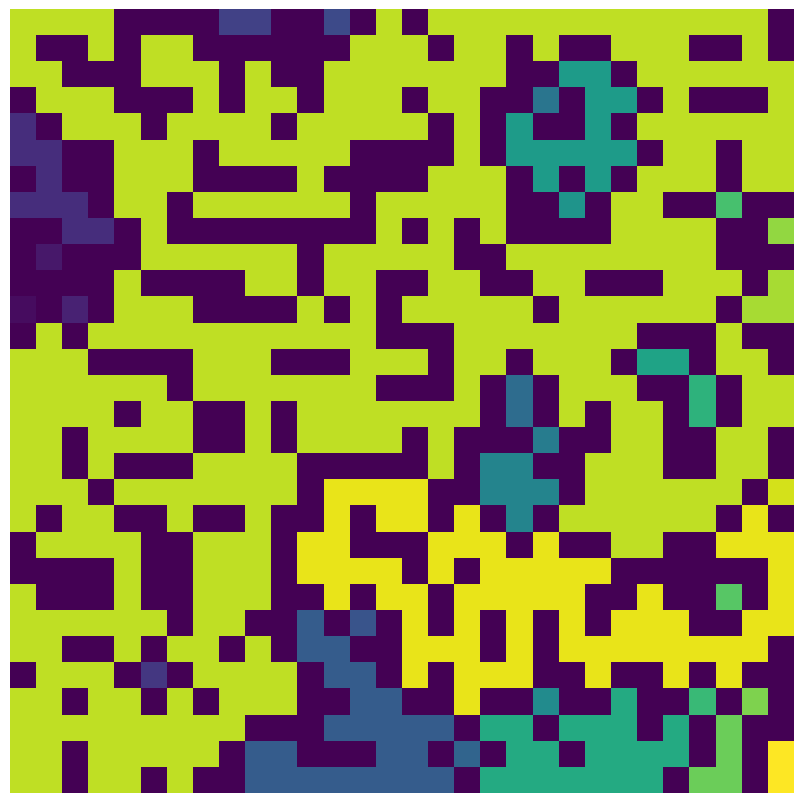

In [1]:
import tkinter as tk
from tkinter import ttk
import torch
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from common import find_clusters_bounded,find_clusters_circular


def sample_classic_percolation(size, p, device):
    A = torch.rand((size, size),device=device)
    A[A >= p] = 1
    A[A < p] = 0
    return A

# Assume these functions exist
# from your_module import find_clusters_bounded, find_clusters_circular

class ClusterApp(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Cluster Generator")
        self.geometry("500x250")

        # Parameters
        tk.Label(self, text="Matrix size:").grid(row=0, column=0, sticky='w')
        self.size_var = tk.IntVar(value=300)
        tk.Entry(self, textvariable=self.size_var).grid(row=0, column=1)

        tk.Label(self, text="Probability p:").grid(row=1, column=0, sticky='w')
        self.p_var = tk.DoubleVar(value=0.6)
        tk.Entry(self, textvariable=self.p_var).grid(row=1, column=1)

        tk.Label(self, text="Clustering algorithm:").grid(row=2, column=0, sticky='w')
        self.algorithm_var = tk.StringVar(value="find_clusters_bounded")
        algo_combo = ttk.Combobox(self, textvariable=self.algorithm_var, values=[
            "find_clusters_bounded", "find_clusters_circular"], state='readonly')
        algo_combo.grid(row=2, column=1)

        # Generate button
        tk.Button(self, text="Generate", command=self.generate).grid(row=3, column=0, columnspan=2, pady=10)

        # Hold references to figures and canvases
        self.fig_A = self.canvas_A = self.win_A = None
        self.fig_C = self.canvas_C = self.win_clusters = None
        self.fig_H = self.canvas_H = self.win_hist = None

    def generate(self):
        size = self.size_var.get()
        p = 1-self.p_var.get()
        algo_name = self.algorithm_var.get()

        device='cuda' if torch.cuda.is_available() else 'cpu'
        # Generate binary matrix
        A = sample_classic_percolation(size, p, device)

        # Compute clusters
        if algo_name == "find_clusters_bounded":
            clusters = find_clusters_bounded(A)
        else:
            clusters = find_clusters_circular(A)

        # Prepare cluster colors
        mask = clusters > 0
        clusters_slice = clusters[mask]
        n_clusters = clusters_slice.max() if mask.any() else 1
        colors = torch.linspace(0, 1, n_clusters + 1,device=device)[clusters]
        colors[clusters == -1] = 0

        # Compute log-histogram of cluster sizes
        cluster_distribution = [(clusters == c).sum() for c in clusters.unique()]
        cluster_distribution = torch.tensor(cluster_distribution)
        cluster_distribution = cluster_distribution[cluster_distribution.argsort()]
        # skip background and largest cluster
        dist = cluster_distribution[:-2]
        log_dist = torch.log(dist.float())

        # --- Update or create plots ---

        # Binary matrix window
        if self.win_A is None or not tk.Toplevel.winfo_exists(self.win_A):
            self.win_A = tk.Toplevel(self)
            self.win_A.title("Binary matrix A")
            self.fig_A, ax_A = plt.subplots(figsize=(8,8))
            self.canvas_A = FigureCanvasTkAgg(self.fig_A, master=self.win_A)
            self.canvas_A.get_tk_widget().pack()
        else:
            ax_A = self.fig_A.axes[0]
            ax_A.clear()
        ax_A.imshow(A.T.cpu(), cmap='gray')
        ax_A.axis('off')
        self.fig_A.tight_layout()
        self.canvas_A.draw()

        # Cluster colors window
        if self.win_clusters is None or not tk.Toplevel.winfo_exists(self.win_clusters):
            self.win_clusters = tk.Toplevel(self)
            self.win_clusters.title("Clusters")
            self.fig_C, ax_C = plt.subplots(figsize=(8,8))
            self.canvas_C = FigureCanvasTkAgg(self.fig_C, master=self.win_clusters)
            self.canvas_C.get_tk_widget().pack()
        else:
            ax_C = self.fig_C.axes[0]
            ax_C.clear()
        ax_C.imshow(colors.T.cpu())
        ax_C.axis('off')
        self.fig_C.tight_layout()
        self.canvas_C.draw()

        # Log-histogram window
        if self.win_hist is None or not tk.Toplevel.winfo_exists(self.win_hist):
            self.win_hist = tk.Toplevel(self)
            self.win_hist.title("Log-histogram of cluster sizes")
            self.fig_H, ax_H = plt.subplots(figsize=(8,6))
            self.canvas_H = FigureCanvasTkAgg(self.fig_H, master=self.win_hist)
            self.canvas_H.get_tk_widget().pack()
        else:
            ax_H = self.fig_H.axes[0]
            ax_H.clear()
        dist=1.0*dist
        ax_H.hist(dist.cpu(),density=True)
        ax_H.set_title(f"Mean cluster size {dist.mean():0.2f}+-{dist.std():0.2f}")
        ax_H.set_xlabel("Cluster ID")
        ax_H.set_ylabel("Cluster size")
        self.fig_H.tight_layout()
        self.canvas_H.draw()



if __name__ == "__main__":
    app = ClusterApp()
    app.mainloop()
